# Introduction to Neural Networks with PyTorch: An End-to-End Example in Healthcare

## 1. Introduction
Welcome! In this notebook, you will learn the basics of training a neural network using PyTorch. We will use a real-world medical image dataset, build a deep neural network, and walk through all the steps from data loading to evaluation and visualization.

## 2. Setup and Imports

In [1]:
# Install required packages (uncomment if running for the first time)
# !pip install torch torchvision medmnist matplotlib scikit-learn seaborn tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import medmnist
from medmnist import INFO, Evaluator
import random

# For reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   - -------------------------------------- 6.6/216.1 MB 33.5 MB/s eta 0:00:07
   -- ------------------------------------- 14.7/216.1 MB 37.7 MB/s eta 0:00:06
   ---- ----------------------------------- 23.1/216.1 MB 38.7 MB/s eta 0:00:05
   ----- ---------------------------------- 32.0/216.1 MB 39.3 MB/s eta 0:00:05
   ------- -------------------------------- 40.4/216.1 MB 39.8 MB/s eta 0:00:05
   --------- ------------------------------ 48.8/216.1 MB 40.2 MB/s eta 0:00:05
   --------- ------------------------------ 51.9/216.1 MB 36.5 MB/s eta 0:00:05
   ---------- ----------------------------- 56.9/216.1 MB 34.9 MB/s eta 0:00:05
   ------------ --------------------------- 65.3/216.1 MB 35.6 MB/s eta 0:00:05
   ------------- -------------------------- 73.7/216.1 MB 36.2 MB/s eta 0:00:04
   --------------- ---------

## 3. Download and Prepare the Data
We will use the ``PathMNIST`` dataset, a subset of MedMNIST, which contains histopathologic images of colorectal cancer.

In [2]:
# Dataset info
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Download datasets
train_dataset = DataClass(split='train', transform=transform, download=download)
val_dataset = DataClass(split='val', transform=transform, download=download)
test_dataset = DataClass(split='test', transform=transform, download=download)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

100%|██████████| 206M/206M [02:37<00:00, 1.31MB/s] 


Train samples: 89996
Validation samples: 10004
Test samples: 7180


## 4. Visualize Example Data

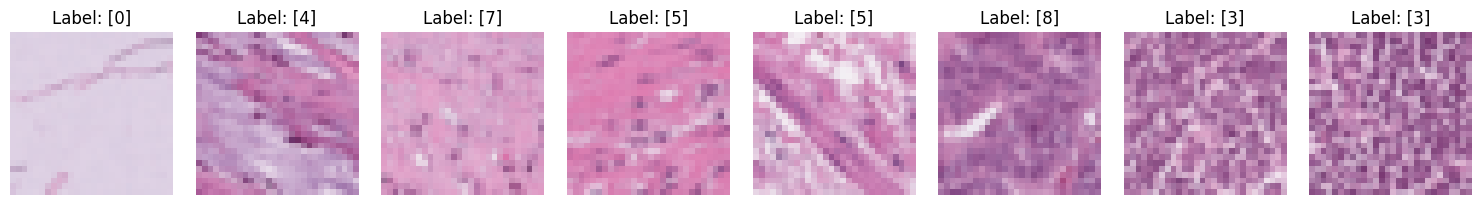

In [5]:
def show_images(dataset, n=8):
    fig, axes = plt.subplots(1, n, figsize=(15, 2))
    for i in range(n):
        img, label = dataset[i]
        img = img.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
        # Unnormalize: x * std + mean (here, mean=0.5, std=0.5)
        img = img * 0.5 + 0.5
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_images(train_dataset)

## 5. Data Preprocessing and DataLoaders

In [6]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## 6. Define the Model Architecture
We will use a modern convolutional neural network (CNN) with several million parameters.

In [7]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 3 * 3, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = len(info['label'])
model = CNNModel(num_classes)
print(model)

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool

## 7. Loss Function, Optimizer, and Device

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 8. Training and Validation Loop

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            images, labels = images.to(device), labels.squeeze().to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                images, labels = images.to(device), labels.squeeze().to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        val_loss = running_loss / total
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=epochs
)

Epoch 1/10 [Val]: 100%|██████████| 79/79 [00:21<00:00,  3.64it/s]


Epoch 1: Train Loss=0.5659, Train Acc=0.8024, Val Loss=0.3393, Val Acc=0.8859


Epoch 2/10 [Val]: 100%|██████████| 79/79 [00:21<00:00,  3.63it/s]


Epoch 2: Train Loss=0.2487, Train Acc=0.9148, Val Loss=0.3737, Val Acc=0.8824


Epoch 3/10 [Val]: 100%|██████████| 79/79 [00:21<00:00,  3.62it/s]


Epoch 3: Train Loss=0.1698, Train Acc=0.9435, Val Loss=0.2075, Val Acc=0.9329


Epoch 4/10 [Val]: 100%|██████████| 79/79 [00:21<00:00,  3.61it/s]


Epoch 4: Train Loss=0.1282, Train Acc=0.9571, Val Loss=0.1844, Val Acc=0.9393


Epoch 5/10 [Val]: 100%|██████████| 79/79 [00:21<00:00,  3.62it/s]


Epoch 5: Train Loss=0.1081, Train Acc=0.9640, Val Loss=0.8051, Val Acc=0.8122


Epoch 6/10 [Val]: 100%|██████████| 79/79 [00:31<00:00,  2.48it/s]


Epoch 6: Train Loss=0.1008, Train Acc=0.9668, Val Loss=0.3108, Val Acc=0.9115


Epoch 7/10 [Val]: 100%|██████████| 79/79 [00:27<00:00,  2.90it/s]


Epoch 7: Train Loss=0.0761, Train Acc=0.9746, Val Loss=0.1077, Val Acc=0.9646


Epoch 8/10 [Val]: 100%|██████████| 79/79 [00:20<00:00,  3.90it/s]


Epoch 8: Train Loss=0.0653, Train Acc=0.9775, Val Loss=0.1394, Val Acc=0.9557


Epoch 9/10 [Val]: 100%|██████████| 79/79 [00:26<00:00,  2.96it/s]


Epoch 9: Train Loss=0.0550, Train Acc=0.9816, Val Loss=0.2705, Val Acc=0.9313


Epoch 10/10 [Val]: 100%|██████████| 79/79 [00:21<00:00,  3.68it/s]

Epoch 10: Train Loss=0.0529, Train Acc=0.9820, Val Loss=0.1822, Val Acc=0.9541


## 9. Plot Training and Validation Metrics

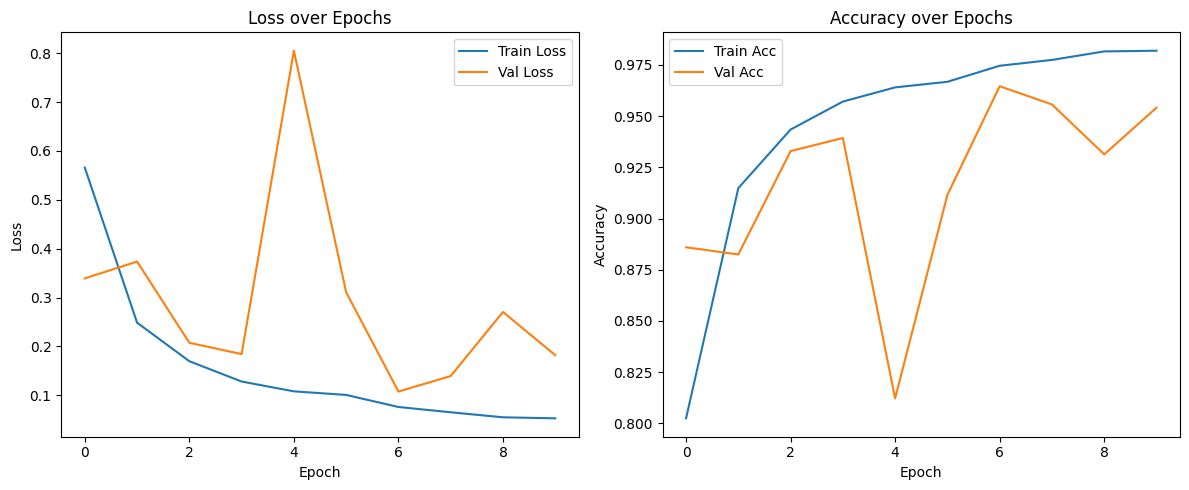

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

## 10. Evaluate on Test Set

In [11]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.squeeze().to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=info['label'].values()))

Testing: 100%|██████████| 57/57 [00:16<00:00,  3.48it/s]

                                      precision    recall  f1-score   support

                             adipose       0.85      0.91      0.88      1338
                          background       0.96      1.00      0.98       847
                              debris       0.71      0.90      0.79       339
                         lymphocytes       0.95      0.97      0.96       634
                               mucus       0.98      0.79      0.88      1035
                       smooth muscle       0.63      0.87      0.73       592
                 normal colon mucosa       0.97      0.90      0.94       741
            cancer-associated stroma       0.92      0.34      0.50       421
colorectal adenocarcinoma epithelium       0.93      0.97      0.95      1233

                            accuracy                           0.88      7180
                           macro avg       0.88      0.85      0.84      7180
                        weighted avg       0.90      0.88     

## 11. Confusion Matrix Visualization

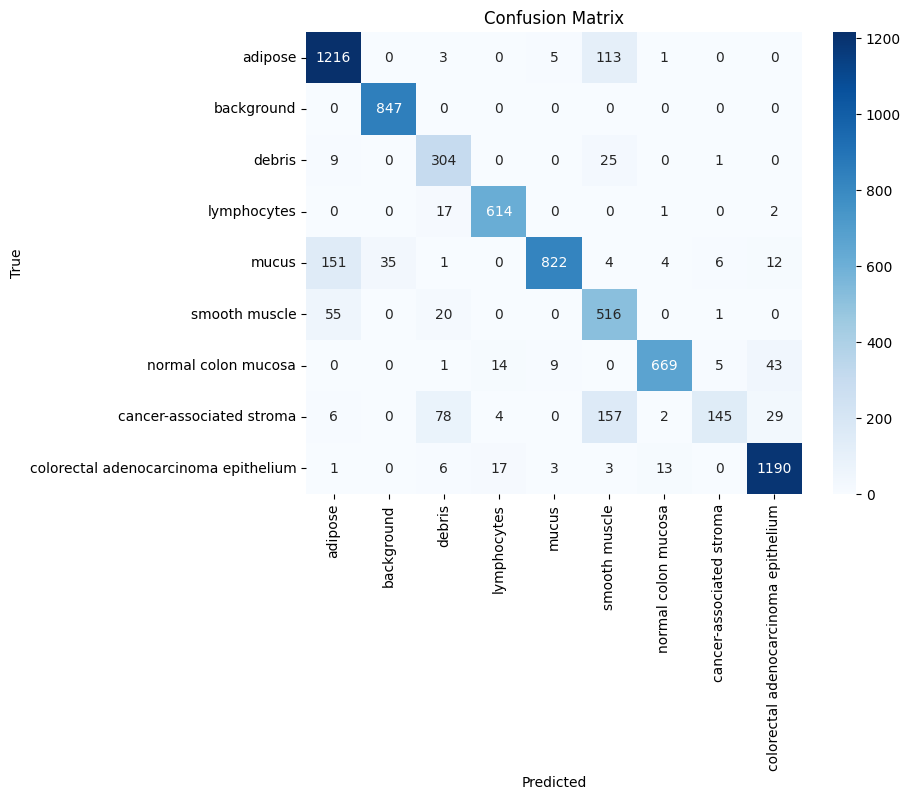

In [12]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 12. Visualize Model Predictions

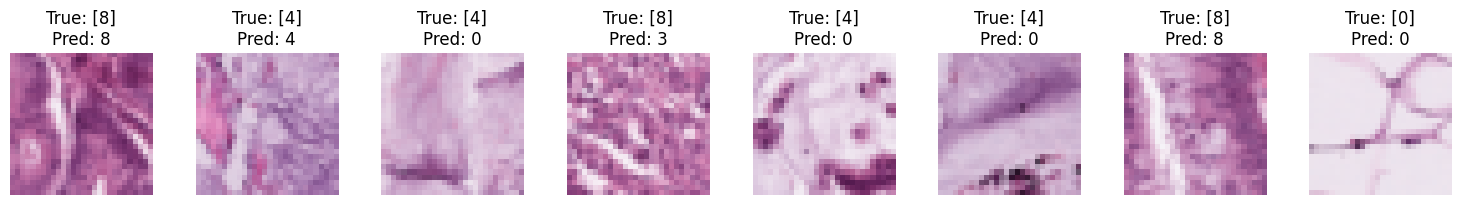

In [14]:
def plot_predictions(dataset, model, n=8):
    model.eval()
    fig, axes = plt.subplots(1, n, figsize=(15, 2))
    for i in range(n):
        img, label = dataset[i]
        img_input = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(img_input)
            pred = output.argmax(dim=1).item()
        
        # Convert to numpy and transpose for display
        img = img.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
        # Unnormalize the image
        img = img * 0.5 + 0.5
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)  # Remove cmap='gray' since these are RGB images
        axes[i].set_title(f"True: {label}\nPred: {pred}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

plot_predictions(test_dataset, model)

## 13. Conclusion
Congratulations! You have trained a deep neural network on a real-world medical image dataset, monitored its performance, and visualized the results. This workflow forms the foundation for more advanced AI applications in healthcare.